In [9]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [10]:
# generated by ChatGPT
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [11]:
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.transform = transform
        # Search recursively for jpg images
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)
        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image or try loading another image
            image = Image.new('RGB', (64, 64), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image


# Define transformations: resize to 64x64, convert to tensor, normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Change the root directory to your dataset location
dataset_root = "./dataset"
weather_dataset = WeatherDataset(root_dir=dataset_root, transform=transform)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


Found 698 images.


In [12]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: downsample image
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 256 x 4 x 4
            nn.ReLU()
        )
        self.flatten_dim = 256 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder: reconstruct image from latent vector
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 3 x 64 x 64
            nn.Tanh()  # output normalized to [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        enc_out = self.encoder(x)
        enc_out = enc_out.view(batch_size, -1)
        mu = self.fc_mu(enc_out)
        logvar = self.fc_logvar(enc_out)
        z = self.reparameterize(mu, logvar)

        dec_input = self.decoder_input(z)
        dec_input = dec_input.view(batch_size, 256, 4, 4)
        reconstruction = self.decoder(dec_input)
        return reconstruction, mu, logvar


In [13]:
def loss_function(recon_x, x, mu, logvar):
    # Mean Squared Error loss for reconstruction
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

vae = VAE(latent_dim=64).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [23]:
num_epochs = 50  # Adjust as needed
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(weather_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 331.3058
Epoch 2/50, Loss: 333.8391
Epoch 3/50, Loss: 335.4062
Epoch 4/50, Loss: 335.0752
Epoch 5/50, Loss: 331.9905
Epoch 6/50, Loss: 333.3855
Epoch 7/50, Loss: 334.7252
Epoch 8/50, Loss: 331.4752
Epoch 9/50, Loss: 331.5723
Epoch 10/50, Loss: 329.2668
Epoch 11/50, Loss: 326.6939
Epoch 12/50, Loss: 327.0041
Epoch 13/50, Loss: 329.0621
Epoch 14/50, Loss: 326.9384
Epoch 15/50, Loss: 327.8711
Epoch 16/50, Loss: 327.7579
Epoch 17/50, Loss: 333.9269
Epoch 18/50, Loss: 330.4755
Epoch 19/50, Loss: 327.6922
Epoch 20/50, Loss: 328.9649
Epoch 21/50, Loss: 326.3185
Epoch 22/50, Loss: 325.9763
Epoch 23/50, Loss: 327.5668
Epoch 24/50, Loss: 328.8384
Epoch 25/50, Loss: 325.8076
Epoch 26/50, Loss: 323.3353
Epoch 27/50, Loss: 325.6607
Epoch 28/50, Loss: 320.0359
Epoch 29/50, Loss: 315.9486
Epoch 30/50, Loss: 315.4298
Epoch 31/50, Loss: 314.9284
Epoch 32/50, Loss: 313.9429
Epoch 33/50, Loss: 319.0512
Epoch 34/50, Loss: 315.9975
Epoch 35/50, Loss: 314.6852
Epoch 36/50, Loss: 312.3696
E

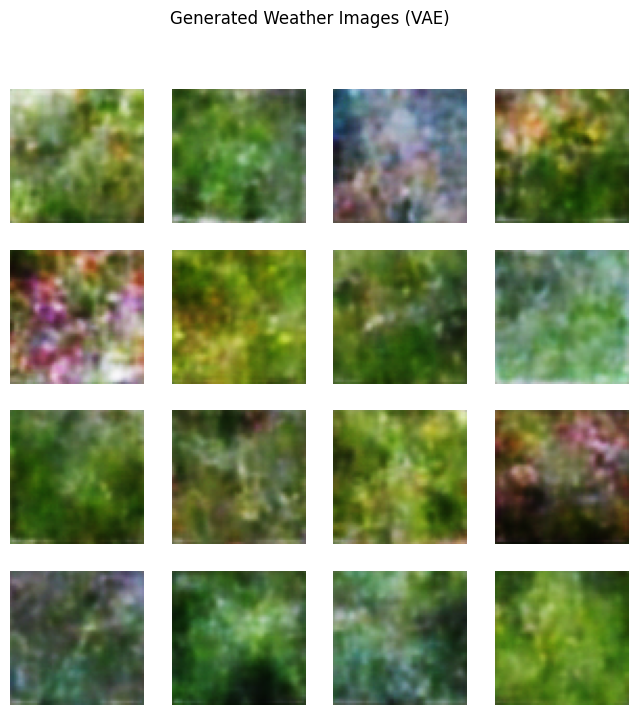

In [24]:
vae.eval()
n_samples = 16
# Sample latent vectors (of size 64)
sampled_z = torch.randn(n_samples, 64).to(device)
with torch.no_grad():
    dec_input = vae.decoder_input(sampled_z)
    dec_input = dec_input.view(n_samples, 256, 4, 4)
    generated = vae.decoder(dec_input).cpu()

# Denormalize images from [-1,1] to [0,1]
generated = (generated + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(generated[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (VAE)")
plt.show()


In [25]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is the latent vector Z
            nn.ConvTranspose2d(nz, 256, kernel_size=4, stride=1, padding=0, bias=False),  # 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),   # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),    # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),     # 3 x 64 x 64
            nn.Tanh()  # outputs in [-1,1]
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),  # 32 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),   # 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)


In [26]:
nz = 100  # dimension of noise vector
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

num_epochs_gan = 50  # Increase for better results!
real_label = 1.
fake_label = 0.

print("Starting GAN Training...")
for epoch in range(num_epochs_gan):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Train with real images
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to label as real
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs_gan}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}")


Starting GAN Training...
[1/50] Loss_D: 0.5478 Loss_G: 3.2268
[2/50] Loss_D: 0.2821 Loss_G: 5.0353
[3/50] Loss_D: 0.1334 Loss_G: 6.5107
[4/50] Loss_D: 0.1732 Loss_G: 6.4152
[5/50] Loss_D: 0.1012 Loss_G: 8.5650
[6/50] Loss_D: 0.0271 Loss_G: 12.6929
[7/50] Loss_D: 0.0073 Loss_G: 9.3190
[8/50] Loss_D: 0.0796 Loss_G: 14.7938
[9/50] Loss_D: 0.0324 Loss_G: 11.0379
[10/50] Loss_D: 0.0256 Loss_G: 7.8759
[11/50] Loss_D: 0.0037 Loss_G: 11.9789
[12/50] Loss_D: 0.0137 Loss_G: 11.2930
[13/50] Loss_D: 0.2040 Loss_G: 10.1767
[14/50] Loss_D: 0.0036 Loss_G: 8.8378
[15/50] Loss_D: 0.0586 Loss_G: 6.6875
[16/50] Loss_D: 0.0376 Loss_G: 6.5088
[17/50] Loss_D: 0.0518 Loss_G: 7.5539
[18/50] Loss_D: 3.1624 Loss_G: 11.9709
[19/50] Loss_D: 0.2232 Loss_G: 5.7080
[20/50] Loss_D: 0.1243 Loss_G: 4.6123
[21/50] Loss_D: 0.6117 Loss_G: 9.4337
[22/50] Loss_D: 0.2495 Loss_G: 6.0924
[23/50] Loss_D: 0.2105 Loss_G: 4.0435
[24/50] Loss_D: 0.2097 Loss_G: 4.5900
[25/50] Loss_D: 0.3380 Loss_G: 4.2195
[26/50] Loss_D: 0.3676 Loss

In [29]:
print("Starting GAN Training...")
for epoch in range(num_epochs_gan):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Train with real images
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to label as real
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs_gan}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}")


Starting GAN Training...
[1/50] Loss_D: 0.6136 Loss_G: 1.1244
[2/50] Loss_D: 0.4520 Loss_G: 3.5887
[3/50] Loss_D: 0.9054 Loss_G: 4.2976
[4/50] Loss_D: 0.5901 Loss_G: 3.1909
[5/50] Loss_D: 0.8135 Loss_G: 3.9015
[6/50] Loss_D: 0.7632 Loss_G: 1.5882
[7/50] Loss_D: 1.0255 Loss_G: 1.8522
[8/50] Loss_D: 0.3523 Loss_G: 2.8190
[9/50] Loss_D: 0.9614 Loss_G: 1.0751
[10/50] Loss_D: 0.3496 Loss_G: 2.8807
[11/50] Loss_D: 1.1318 Loss_G: 3.2709
[12/50] Loss_D: 0.7798 Loss_G: 3.5473
[13/50] Loss_D: 0.4839 Loss_G: 2.6749
[14/50] Loss_D: 0.4731 Loss_G: 3.6798
[15/50] Loss_D: 0.5621 Loss_G: 3.3570
[16/50] Loss_D: 0.4751 Loss_G: 2.2635
[17/50] Loss_D: 0.5314 Loss_G: 3.3622
[18/50] Loss_D: 0.3854 Loss_G: 3.0926
[19/50] Loss_D: 1.3317 Loss_G: 2.1955
[20/50] Loss_D: 0.6682 Loss_G: 1.8291
[21/50] Loss_D: 0.4408 Loss_G: 2.7114
[22/50] Loss_D: 0.4512 Loss_G: 3.0368
[23/50] Loss_D: 0.5745 Loss_G: 4.6511
[24/50] Loss_D: 0.4565 Loss_G: 1.9740
[25/50] Loss_D: 0.5691 Loss_G: 4.9760
[26/50] Loss_D: 0.2939 Loss_G: 3.3

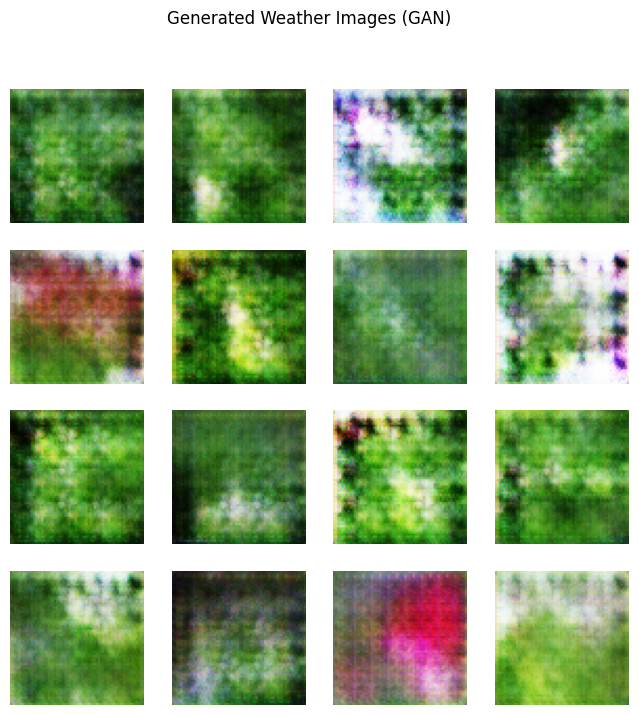

In [30]:
# Generate images from the GAN
netG.eval()
n_samples = 16
noise = torch.randn(n_samples, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(noise).cpu()

# Denormalize from [-1,1] to [0,1]
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1,2,0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (GAN)")
plt.show()
